## Лабораторная работа №1

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import sigmaclip
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

from charts import build_qualitative_charts, build_quantitative_charts

#### Считывание данных

In [2]:
qualitative = ("cat1_gender", "cat7_motivesForEmployeesToWorkBetter")
quantitative = ("num1_6", "num2_6", "num3_6")

data = pd.read_excel("first_practice_dataframe.xlsx", usecols=(*qualitative, *quantitative))
data

,cat1_gender,cat7_motivesForEmployeesToWorkBetter,num1_6,num2_6,num3_6
0,male,Peer motivation,-124.542272,661.478169,440.248041
1,male,Professional growth opportunities,-218.501106,-361.672031,731.825517
2,male,peer motivation,508.244997,39.622829,793.104962
3,NaN,Recognition,-1683.303037,149.510341,761.009556
4,male,Recognition,-808.635822,-178.994837,483.009013
...,...,...,...,...,...
995,male,peer motivation,-266.942610,256.311321,-
996,male,peer motivation,-729.145133,98.024992,685.973776
997,male,Friendly work culture,186.465607,78.434143,648.937931
998,NaN,Recognition,137.124059,227.974470,671.781769


### 1. Визуальный анализ данных

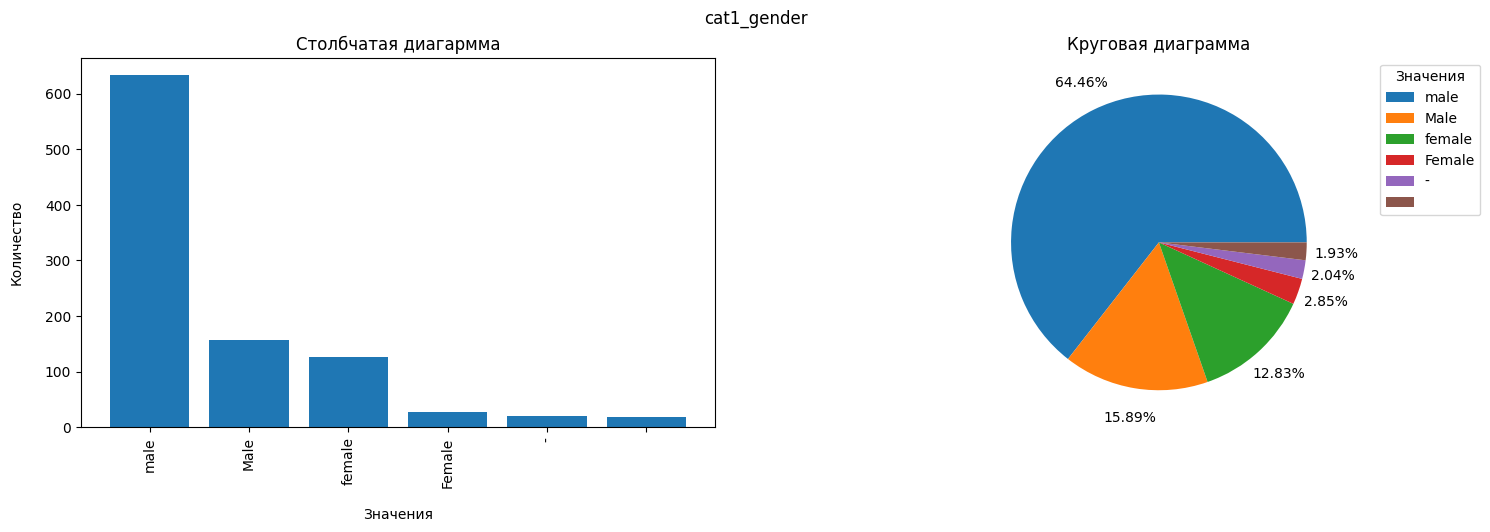

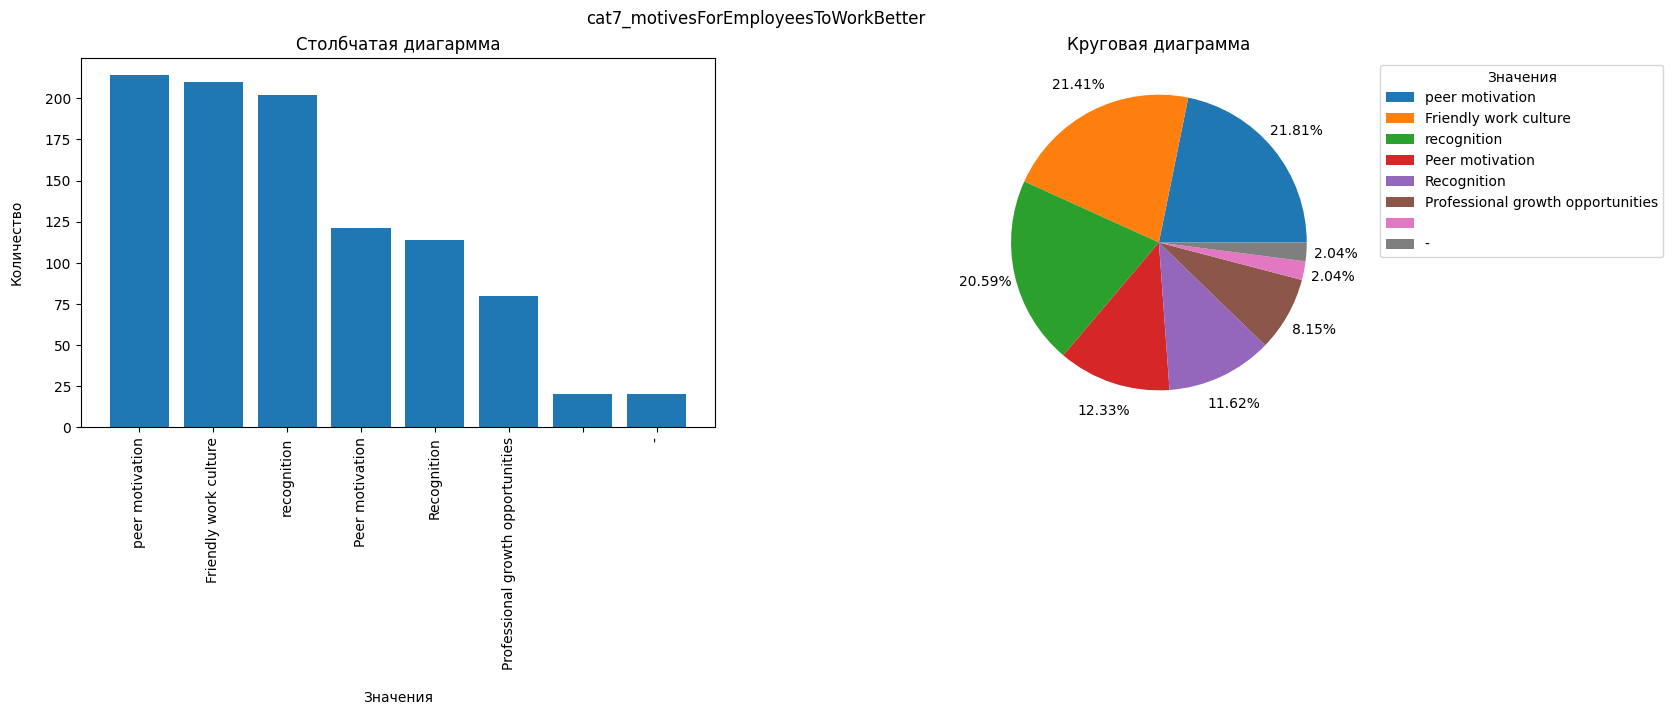

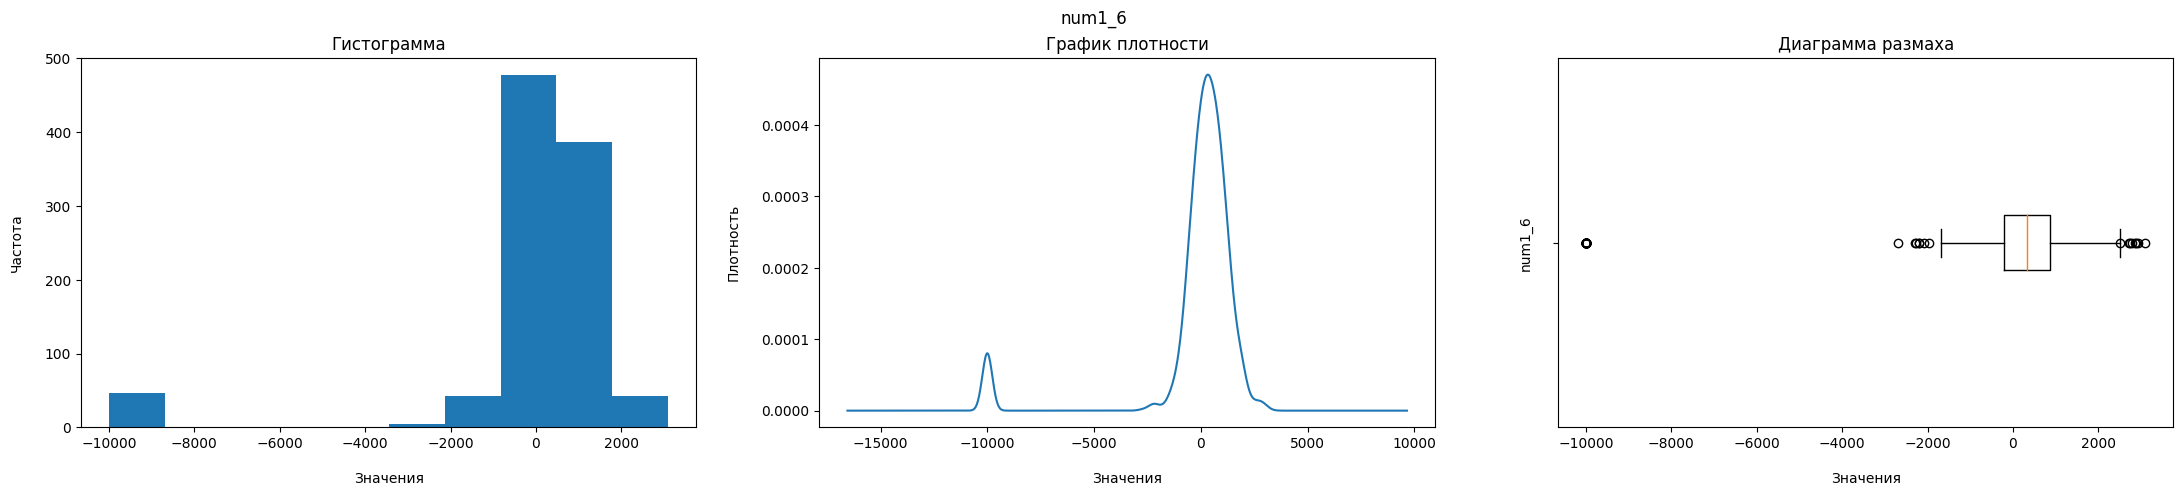

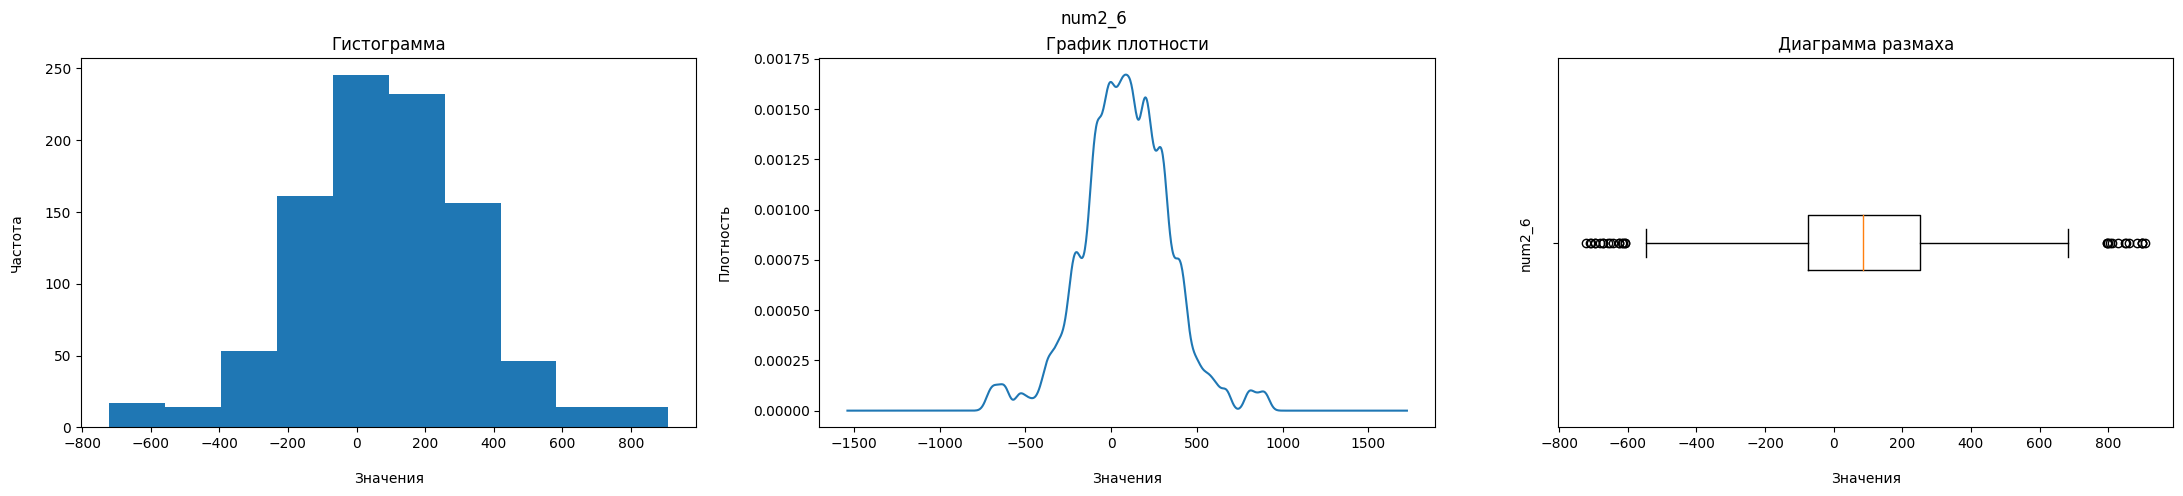

Except num3_6: '<=' not supported between instances of 'float' and 'str'


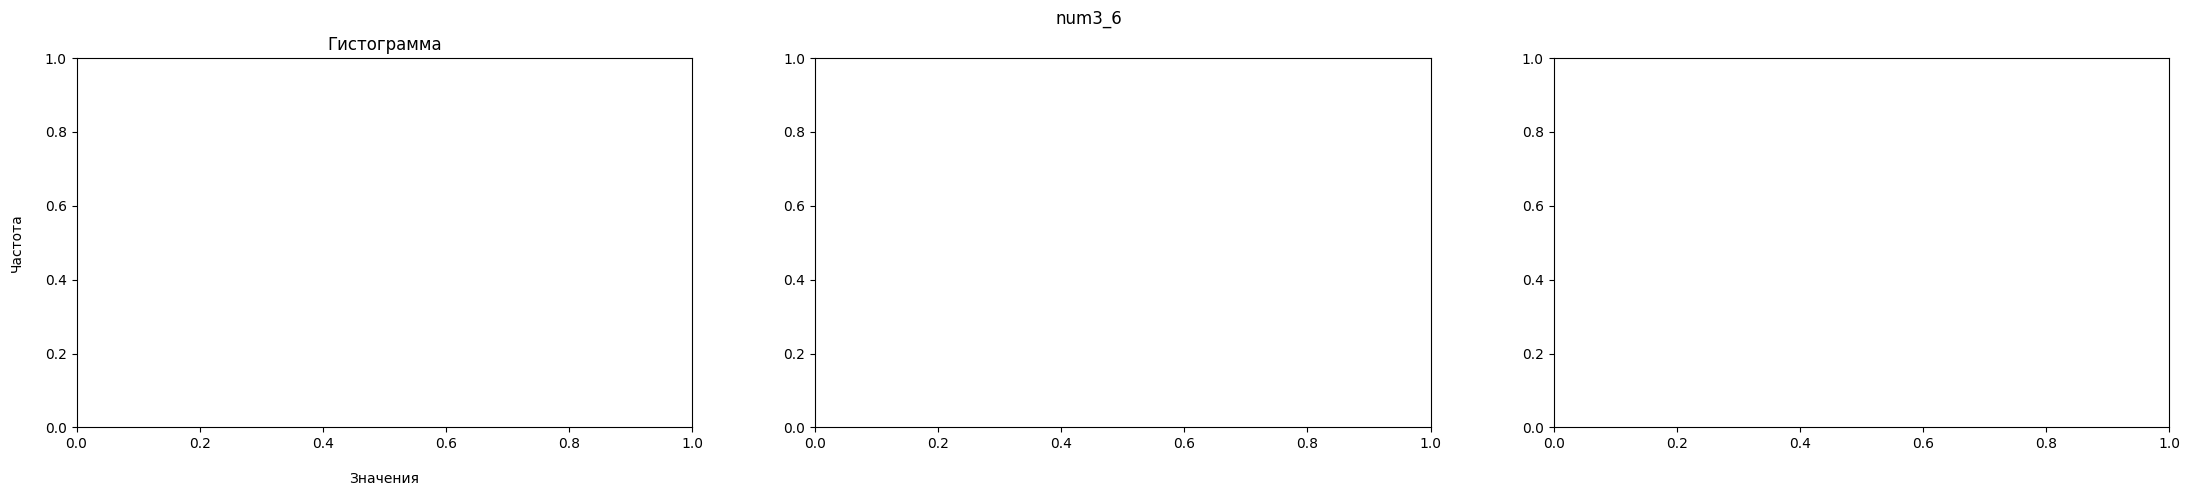

In [3]:
for col in qualitative:
    build_qualitative_charts(data[col], col)

for col in quantitative:
    try:
        build_quantitative_charts(data[col], col)
    except TypeError as e:
        print("Except " + col + ": " + str(e))

Для последней переменной графики не были построены из за ошибки: помимо числовых данных имеются строковые значения

### 2. Проверка правдоподобности исходных данных

Выведем статистику и уникальные значения для каждой переменной

In [4]:
data.info()

for col in qualitative:
    print(data[col].unique())

for col in quantitative:
    print(data[col].apply(lambda x: np.nan if isinstance(x, (int, float)) else x).unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cat1_gender                           982 non-null    object 
 1   cat7_motivesForEmployeesToWorkBetter  981 non-null    object 
 2   num1_6                                1000 non-null   float64
 3   num2_6                                952 non-null    float64
 4   num3_6                                976 non-null    object 
dtypes: float64(2), object(3)
memory usage: 39.2+ KB
['male' nan 'female' 'Male' '-' 'Female' ' ']
['Peer motivation' 'Professional growth opportunities' 'peer motivation'
 'Recognition' 'Friendly work culture' 'recognition' ' ' '-' nan]
[nan]
[nan]
[nan '-' ' ']


Видно, что в данных присутствуют пропуски и другие некорректные значения, например, в последней переменной

Задаем правила изменения и после преобразований снова выводим статистику

In [5]:
for col in qualitative:
    data[col].replace([" ", "-"], np.nan, inplace=True)
    data[col] = data[col].apply(lambda x: x if pd.isna(x) else x.lower())

data[[*quantitative]] = data[[*quantitative]].apply(lambda x: pd.to_numeric(x, "coerce"))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cat1_gender                           943 non-null    object 
 1   cat7_motivesForEmployeesToWorkBetter  941 non-null    object 
 2   num1_6                                1000 non-null   float64
 3   num2_6                                952 non-null    float64
 4   num3_6                                917 non-null    float64
dtypes: float64(3), object(2)
memory usage: 39.2+ KB


Если сравнить текущую статистику с предыдущей, можно увидеть, что увеличилось количество пустых значений, а тип данных серии последней переменной изменился на корректный

### 3. Поиск аномальных значений

#### Метод сигм

In [6]:
sigma_data = data.copy()
sigma = dict(zip(quantitative, ((2.85, 2.88), (2.8, 3.15), (3.25, 4))))

for col in quantitative:

    without_na = sigma_data[col].dropna()
    _, lower, upper = sigmaclip(without_na, *sigma[col])

    dropped = without_na[(without_na < lower) | (without_na > upper)]
    sigma_data.drop(dropped.index, inplace=True)

    sigma_data.reset_index(drop=True, inplace=True)

#### Метод квартилей

In [7]:
quartiles_data = data.copy()

for col in quantitative:

    without_na = quartiles_data[col].dropna()
    q1, q3 = without_na.quantile((0.25, 0.75))
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    dropped = without_na[(without_na < lower) | (without_na > upper)]
    quartiles_data.drop(dropped.index, inplace=True)

    quartiles_data.reset_index(drop=True, inplace=True)

#### Проверка изменений

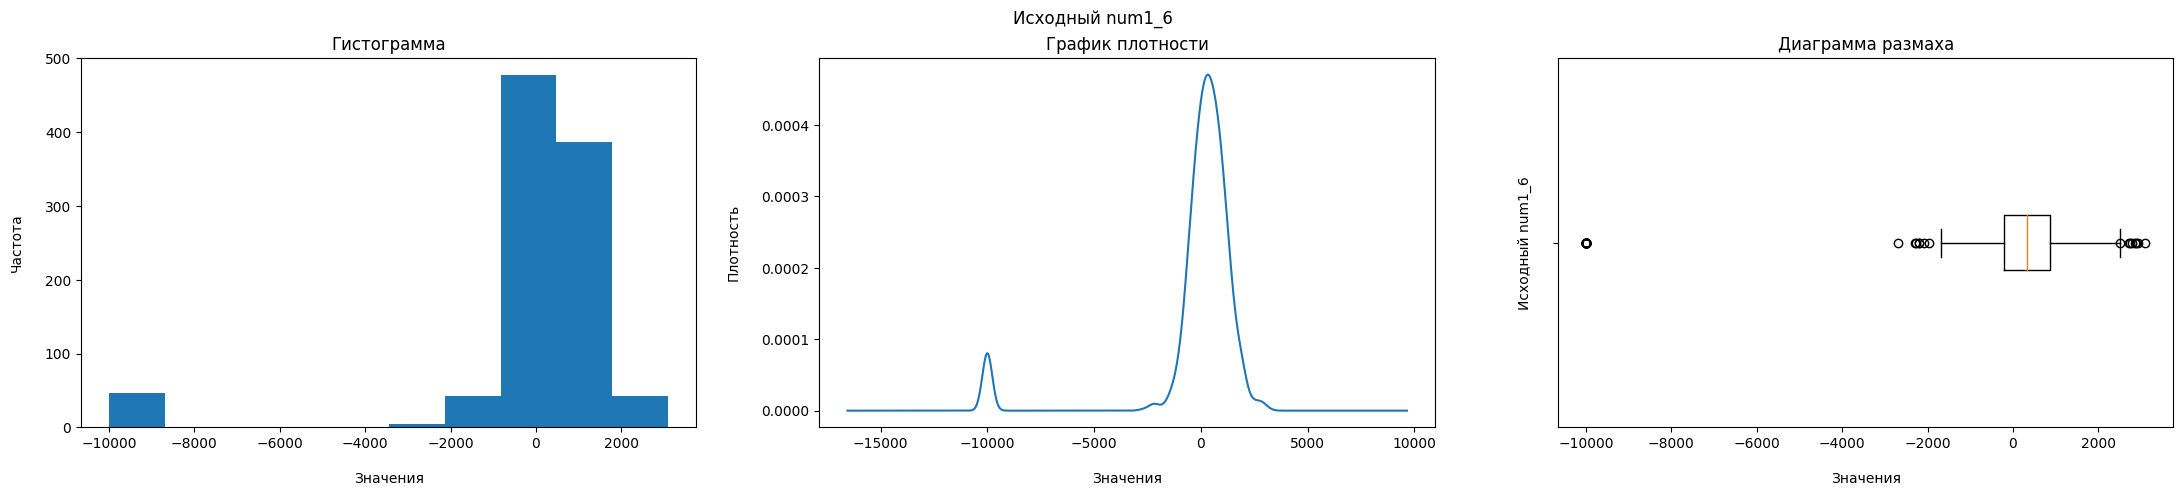

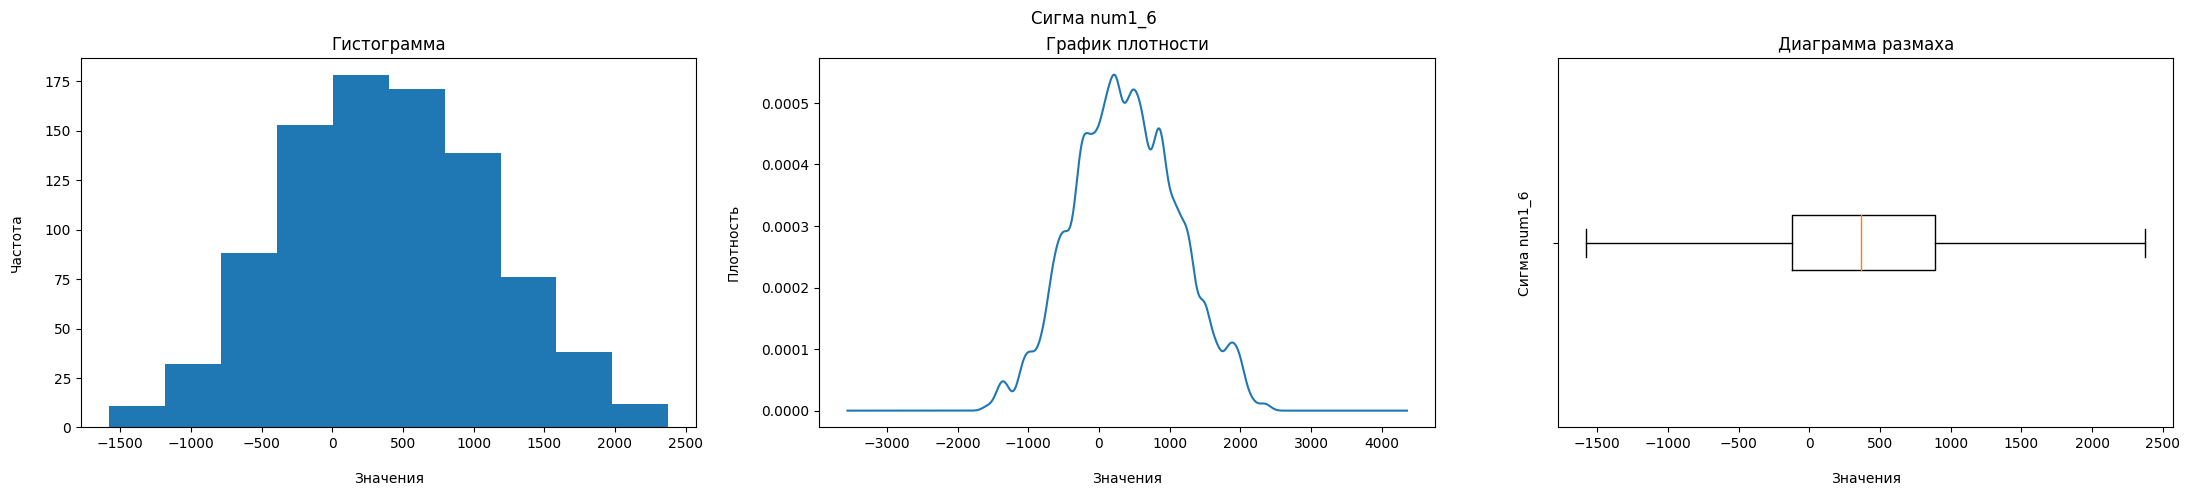

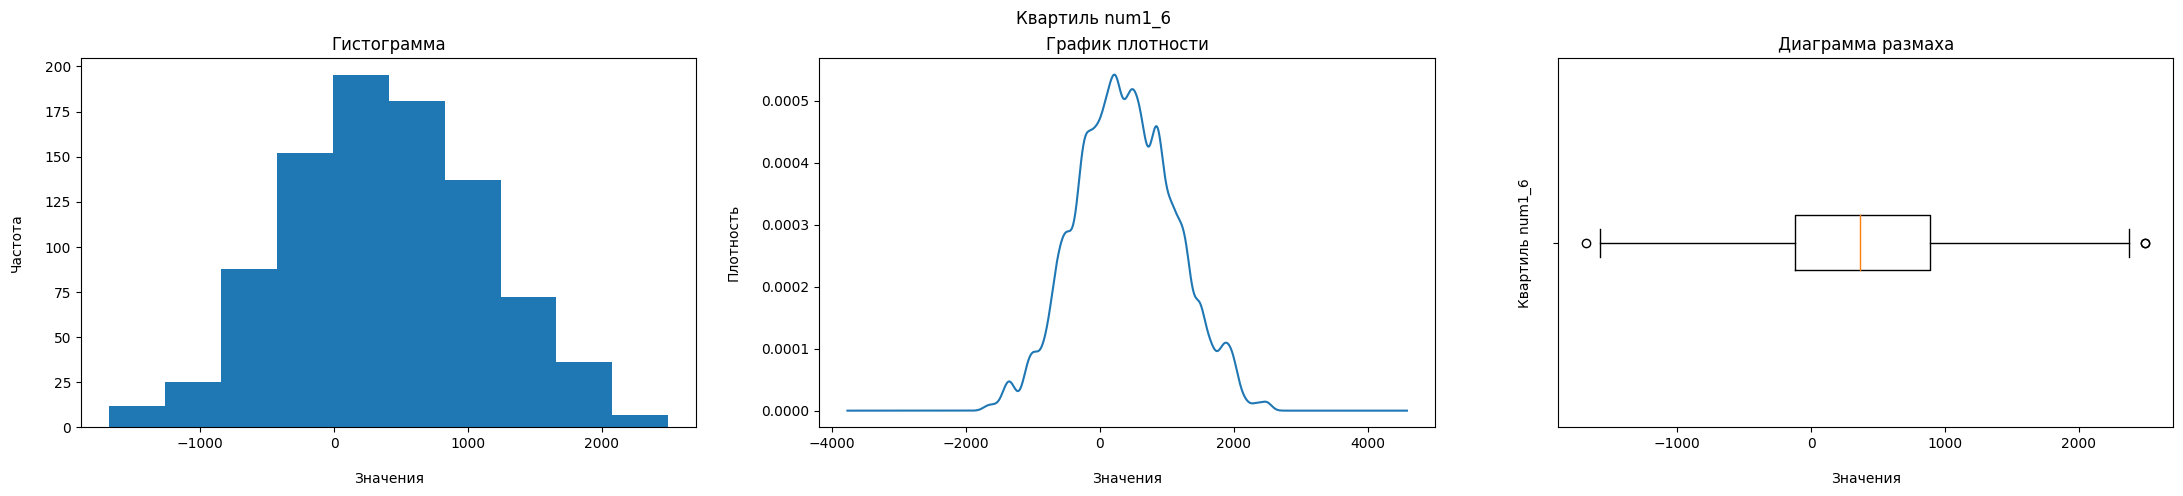

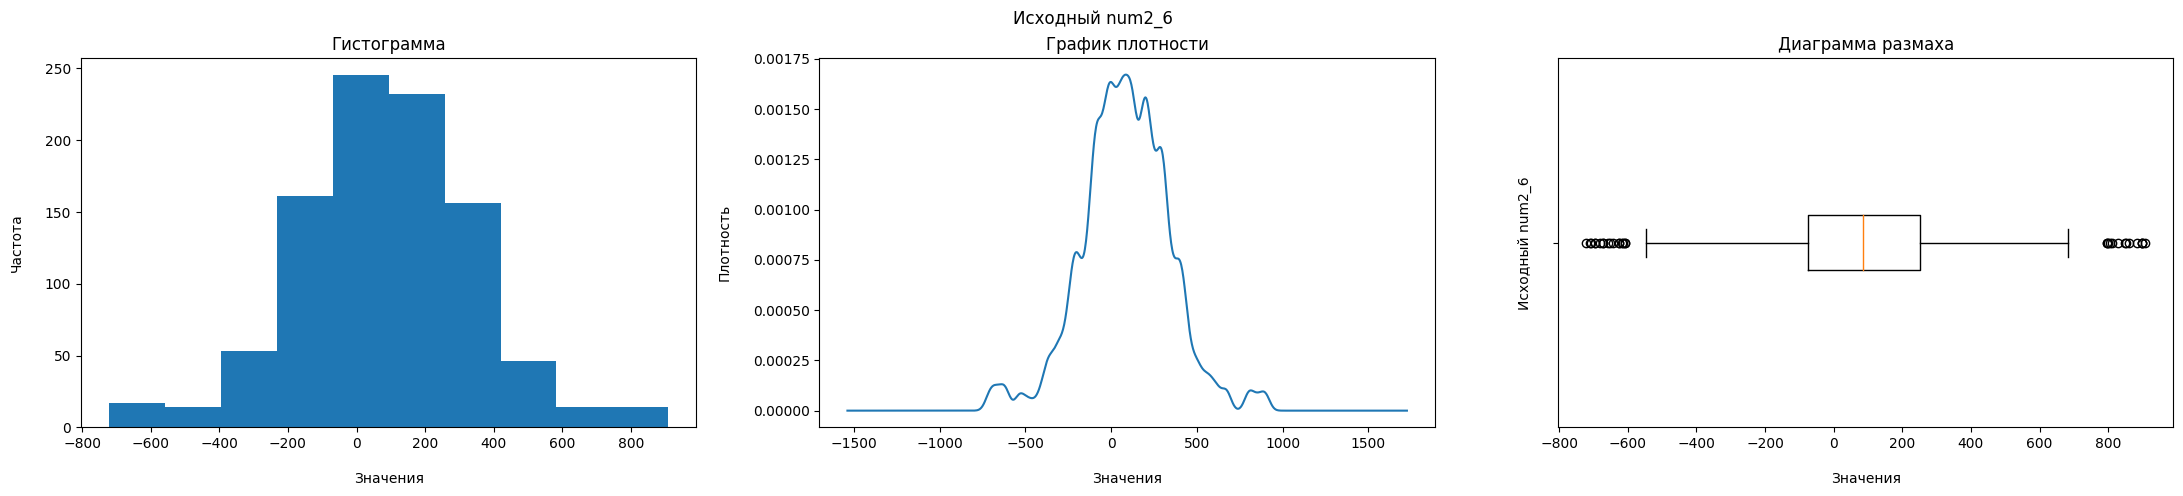

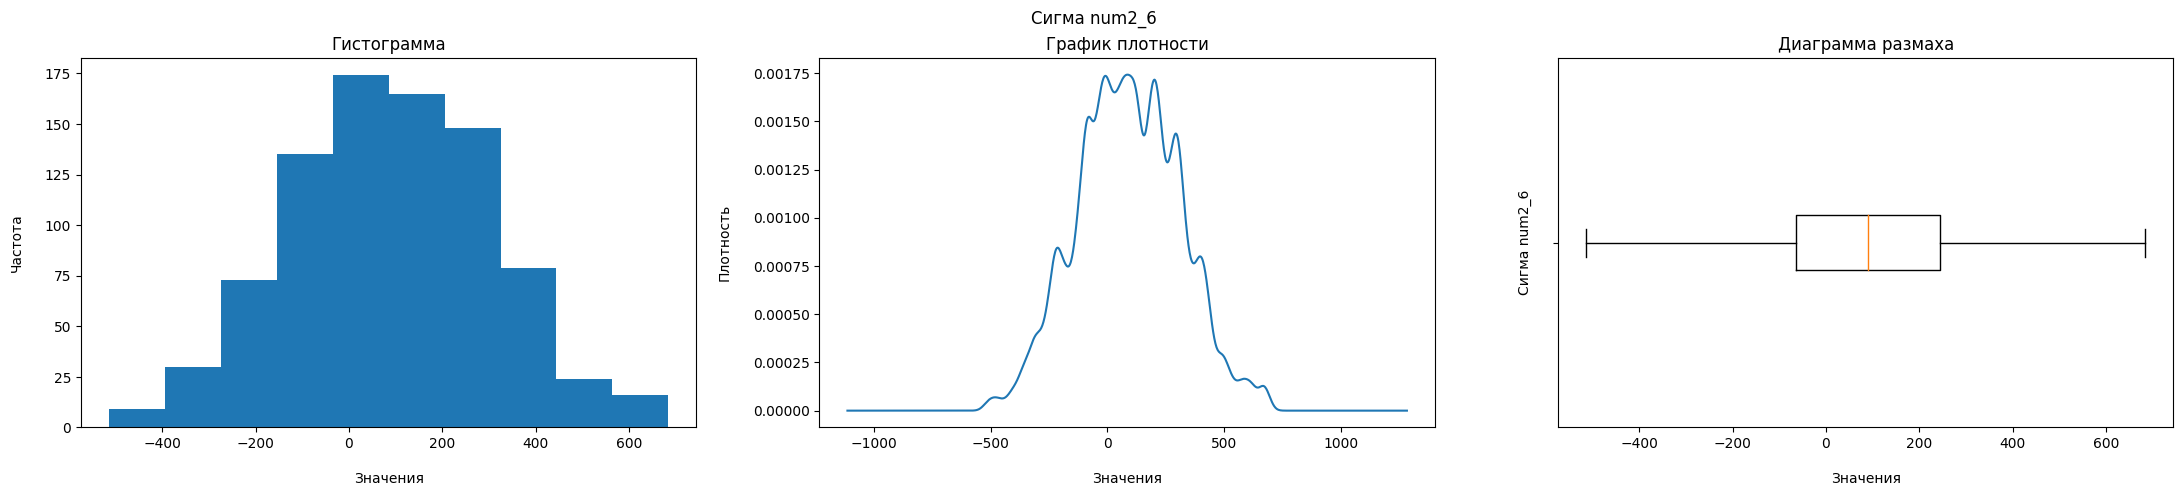

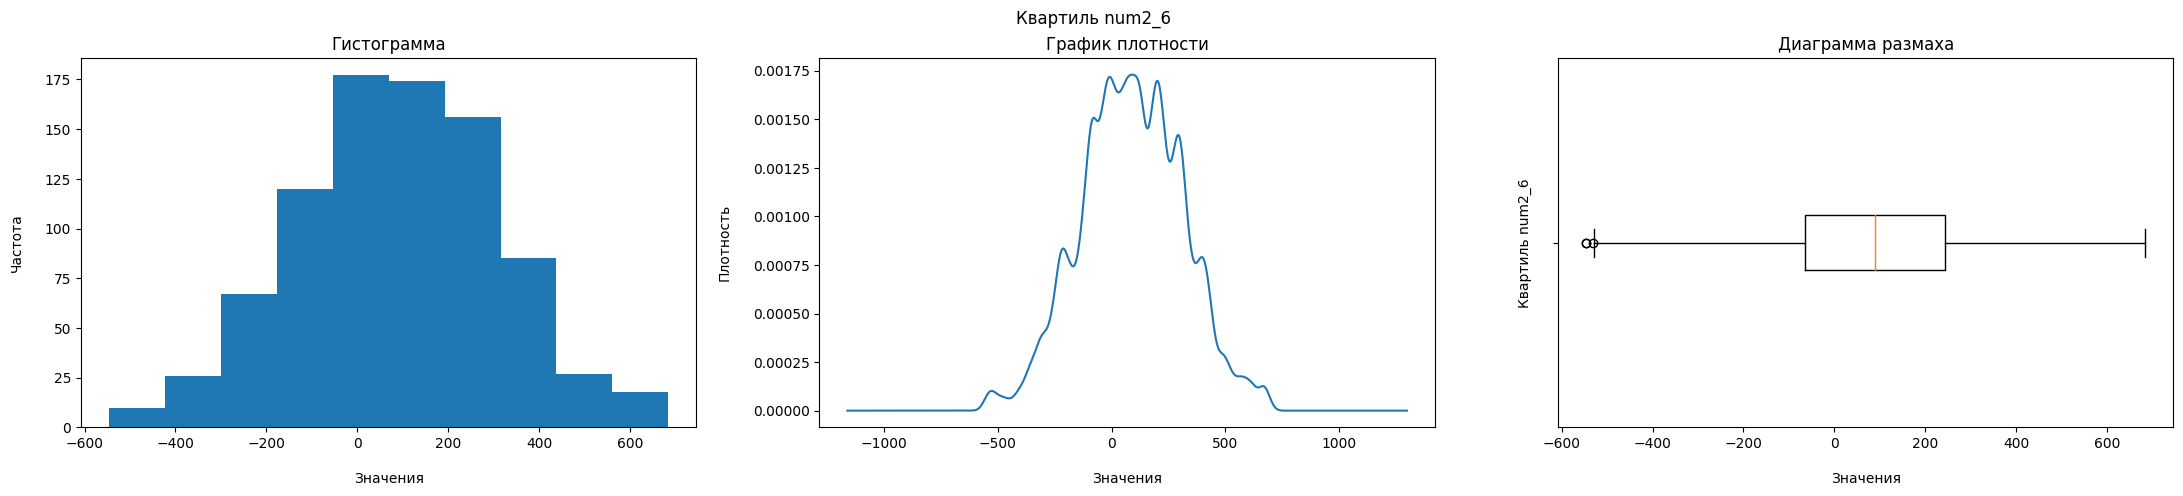

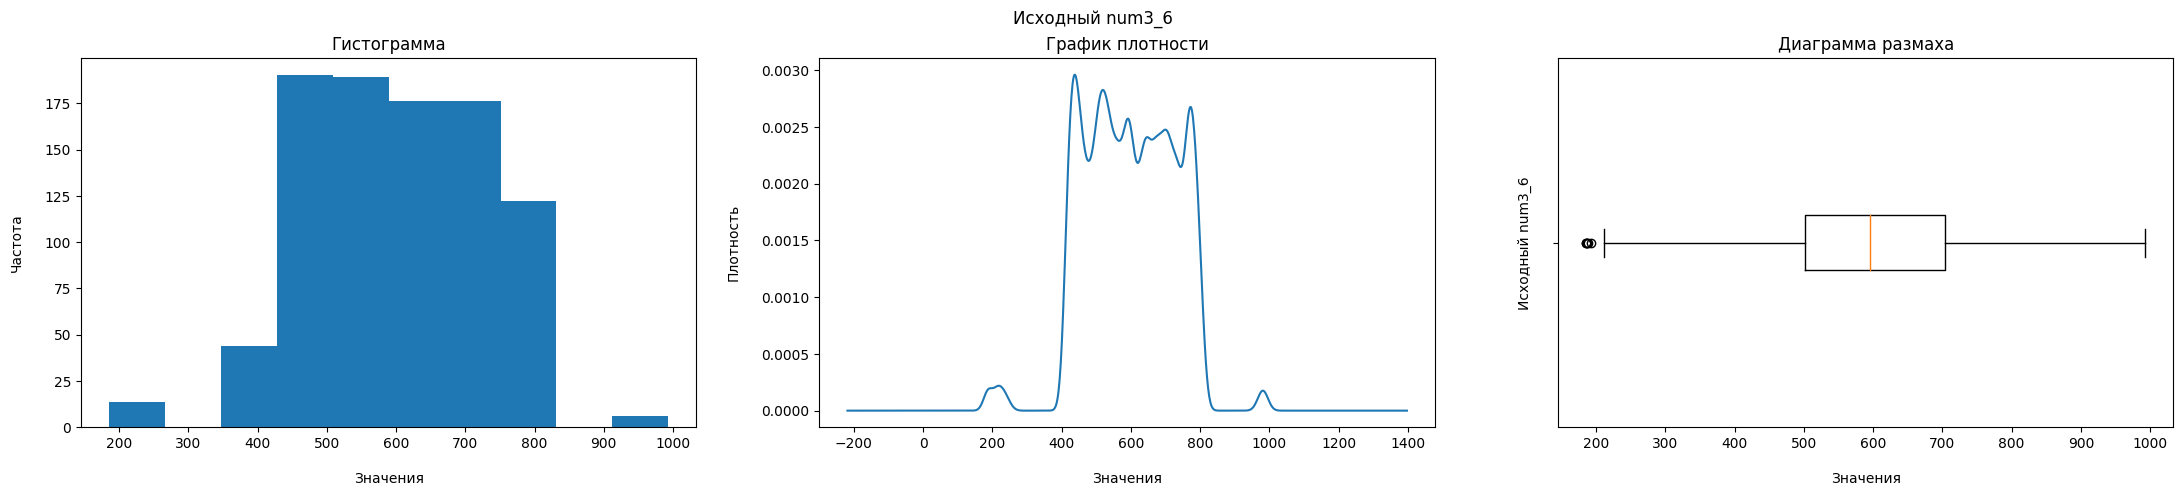

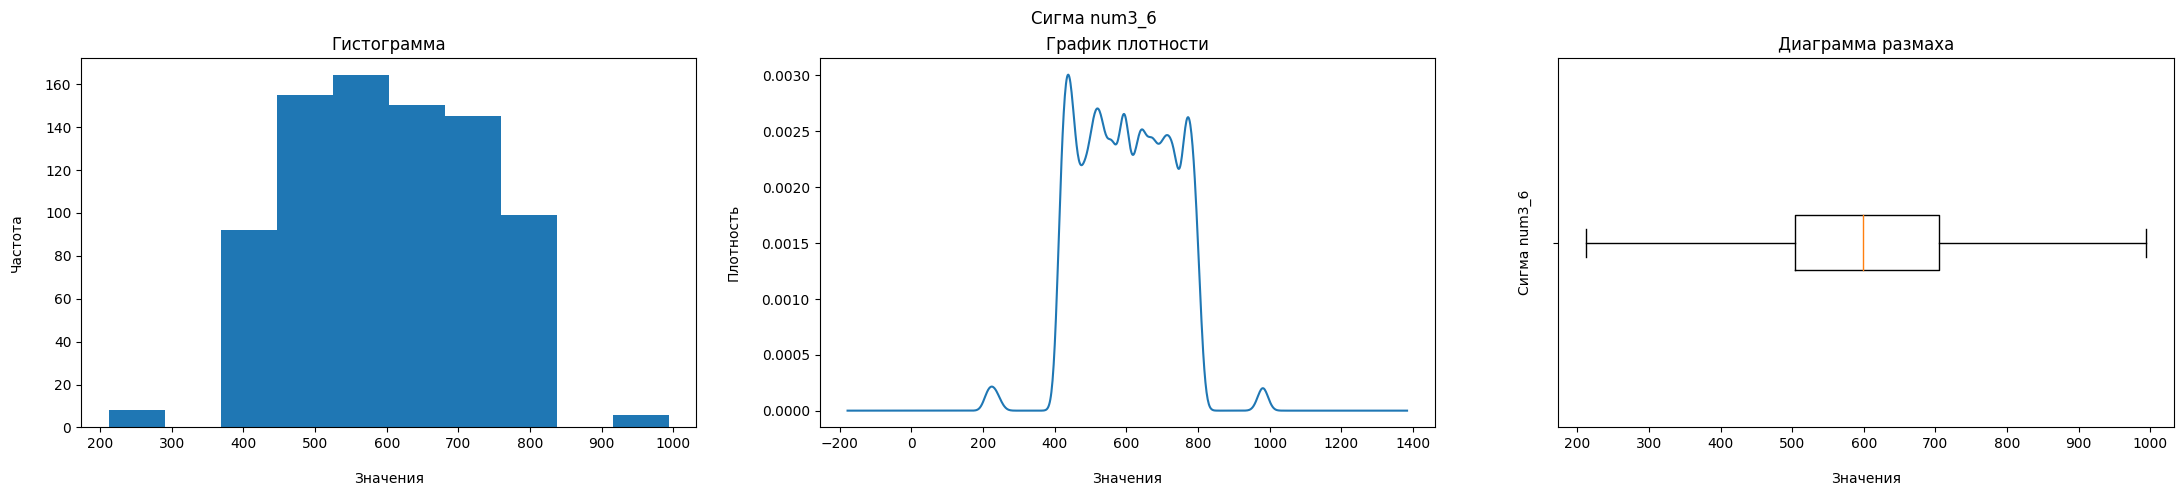

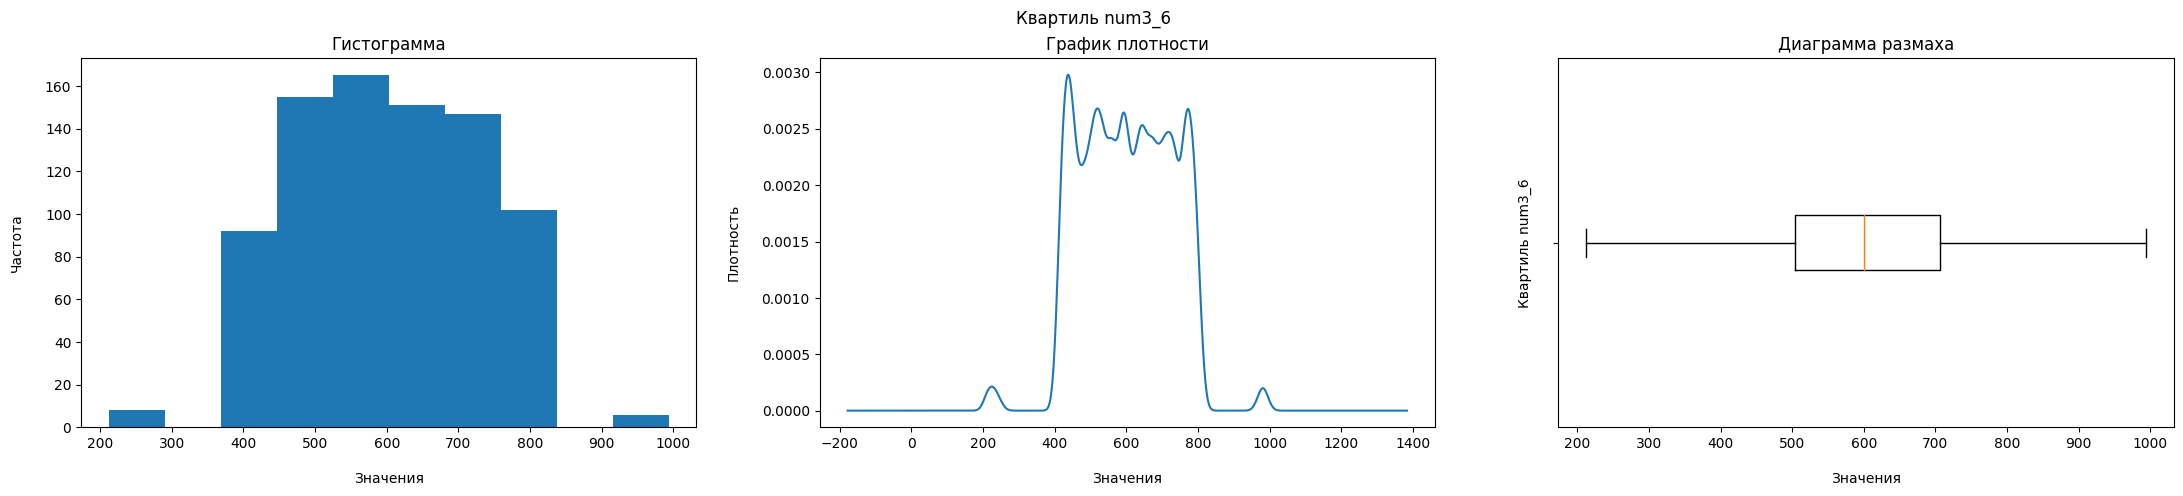

In [8]:
for column in quantitative:
    build_quantitative_charts(data[column], "Исходный " + column)
    build_quantitative_charts(sigma_data[column], "Сигма " + column)
    build_quantitative_charts(quartiles_data[column], "Квартиль " + column)

data = sigma_data.copy()

### 4. Поиск и восстановление пропущенных значений

В начале выведем статистику по количеству пропущенных значений для каждой переменной. Пропуски первой и последней перемнных восстанавливаем методом k-ближайших соседей.

In [9]:
print(data.isna().sum())

knn_imputer = KNNImputer()
encoder = LabelEncoder()

encoded = encoder.fit_transform(data[qualitative[0]])
encoded = np.where(data[qualitative[0]].isna(), np.nan, encoded)
encoded = knn_imputer.fit_transform(encoded.reshape(-1, 1)).round().astype(int)
data[qualitative[0]] = encoder.inverse_transform(encoded.reshape(-1, 1).ravel())

data[[quantitative[2]]] = knn_imputer.fit_transform(data[[quantitative[2]]])

cat1_gender                             52
cat7_motivesForEmployeesToWorkBetter    54
num1_6                                   0
num2_6                                  45
num3_6                                  79
dtype: int64


Пропуски остальных переменных заменим на наиболее частое, среднее и медиану. После восстановления снова выводим статистику.

In [10]:
data[qualitative[1]].fillna(data[qualitative[1]].mode()[0], inplace=True)
data[quantitative[0]].fillna(data[quantitative[0]].mean(), inplace=True)
data[quantitative[1]].fillna(data[quantitative[1]].median(), inplace=True)

data.isna().sum()

cat1_gender                             0
cat7_motivesForEmployeesToWorkBetter    0
num1_6                                  0
num2_6                                  0
num3_6                                  0
dtype: int64

Как видно из статистики, пропущенных значений больше нет

### 5. Преобразование данных

Кодируем категориальные признаки с помощью one-hot и label encodings

In [11]:
encoder = OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(data[[qualitative[0]]]).toarray(), columns=encoder.categories_[0])
data = data.join(encoded.add_prefix(qualitative[0] + "_"))

encoder = LabelEncoder()
data["lb_" + qualitative[1]] = encoder.fit_transform(data[qualitative[1]])

Нормализуем и стандартизируем количественные переменные. Выведем max и min для нормализованных переменных.

In [12]:
for scaler, prefix in ((MinMaxScaler(), "norm_"), (StandardScaler(), "std_")):
    scaled = pd.DataFrame(scaler.fit_transform(data[[*quantitative]]), columns=quantitative)
    data = data.join(scaled.add_prefix(prefix))

for col in quantitative:
    print("Max " + col + ": " + str(data["norm_" + col].max()))
    print("Min " + col + ": " + str(data["norm_" + col].min()))

Max num1_6: 0.9999999999999998
Min num1_6: 0.0
Max num2_6: 1.0
Min num2_6: 0.0
Max num3_6: 1.0
Min num3_6: 0.0


#### Итоговый набор данных

In [13]:
data

,cat1_gender,cat7_motivesForEmployeesToWorkBetter,num1_6,num2_6,num3_6,cat1_gender_female,cat1_gender_male,lb_cat7_motivesForEmployeesToWorkBetter,norm_num1_6,norm_num2_6,norm_num3_6,std_num1_6,std_num2_6,std_num3_6
0,male,peer motivation,-124.542272,661.478169,440.248041,0.0,1.0,1,0.367746,0.980928,0.291796,-0.699279,2.670085,-1.365038
1,male,professional growth opportunities,-218.501106,-361.672031,731.825517,0.0,1.0,2,0.344007,0.127211,0.665172,-0.828530,-2.126873,1.089173
2,male,peer motivation,508.244997,39.622829,793.104962,0.0,1.0,1,0.527617,0.462052,0.743643,0.171188,-0.245434,1.604963
3,male,recognition,-808.635822,-178.994837,483.009013,0.0,1.0,3,0.194912,0.279637,0.346553,-1.640324,-1.270406,-1.005119
4,male,professional growth opportunities,-35.645138,332.217499,652.879365,0.0,1.0,2,0.390205,0.706193,0.564079,-0.576992,1.126373,0.424682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,male,peer motivation,-266.942610,256.311321,602.424153,0.0,1.0,1,0.331769,0.642857,0.499469,-0.895166,0.770493,0.000000
894,male,peer motivation,-729.145133,98.024992,685.973776,0.0,1.0,1,0.214995,0.510783,0.606458,-1.530976,0.028380,0.703238
895,male,friendly work culture,186.465607,78.434143,648.937931,0.0,1.0,0,0.446321,0.494436,0.559032,-0.271454,-0.063470,0.391507
896,male,recognition,137.124059,227.974470,671.781769,0.0,1.0,3,0.433855,0.619212,0.588284,-0.339329,0.637638,0.583784


#### Результат

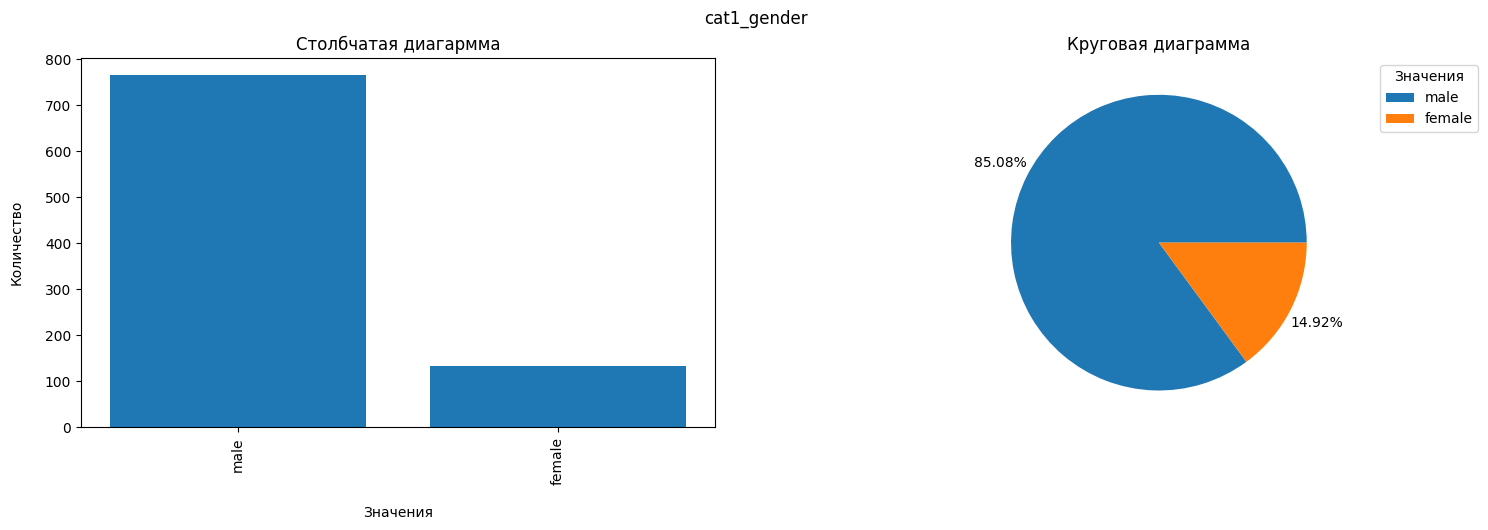

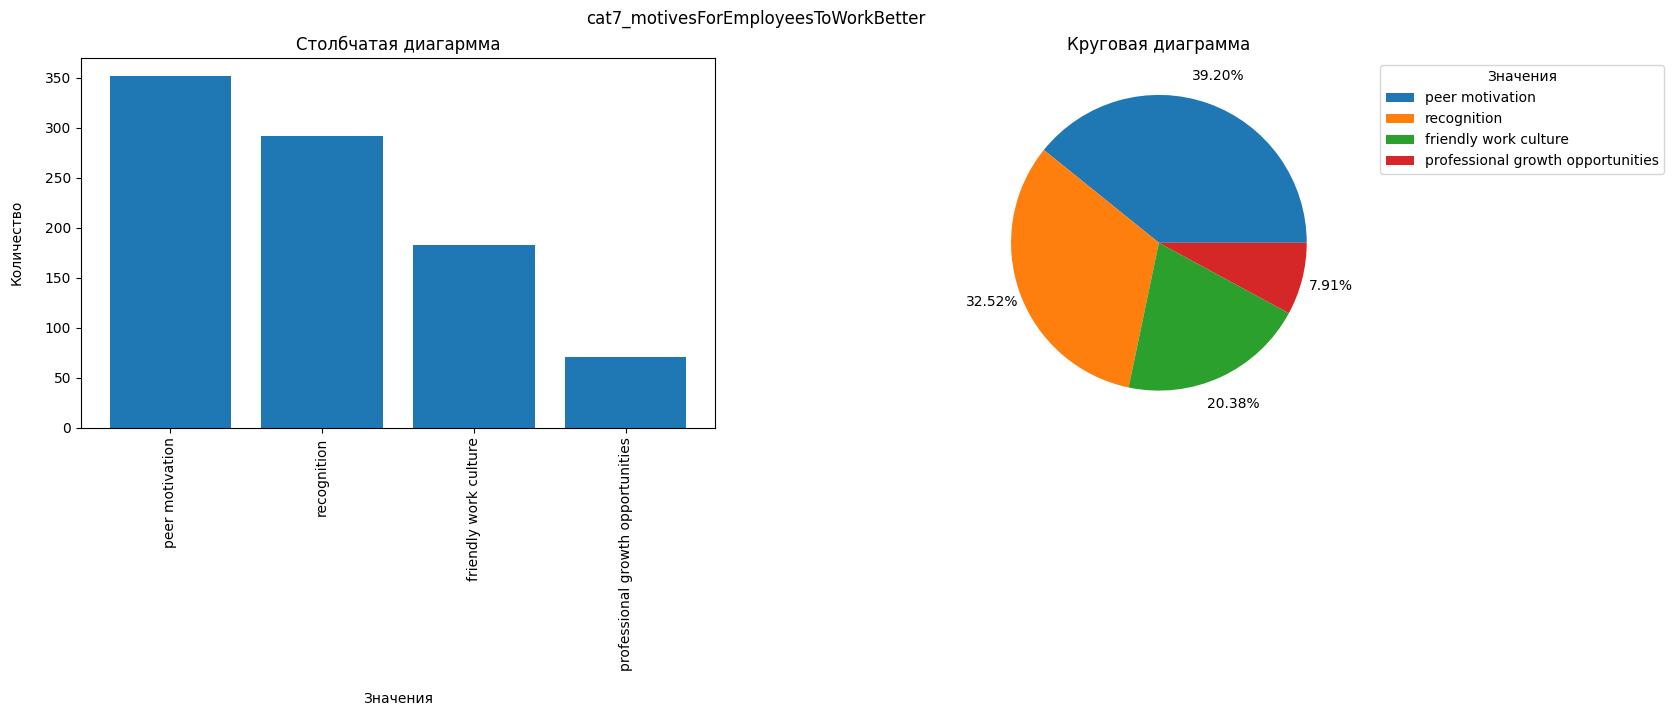

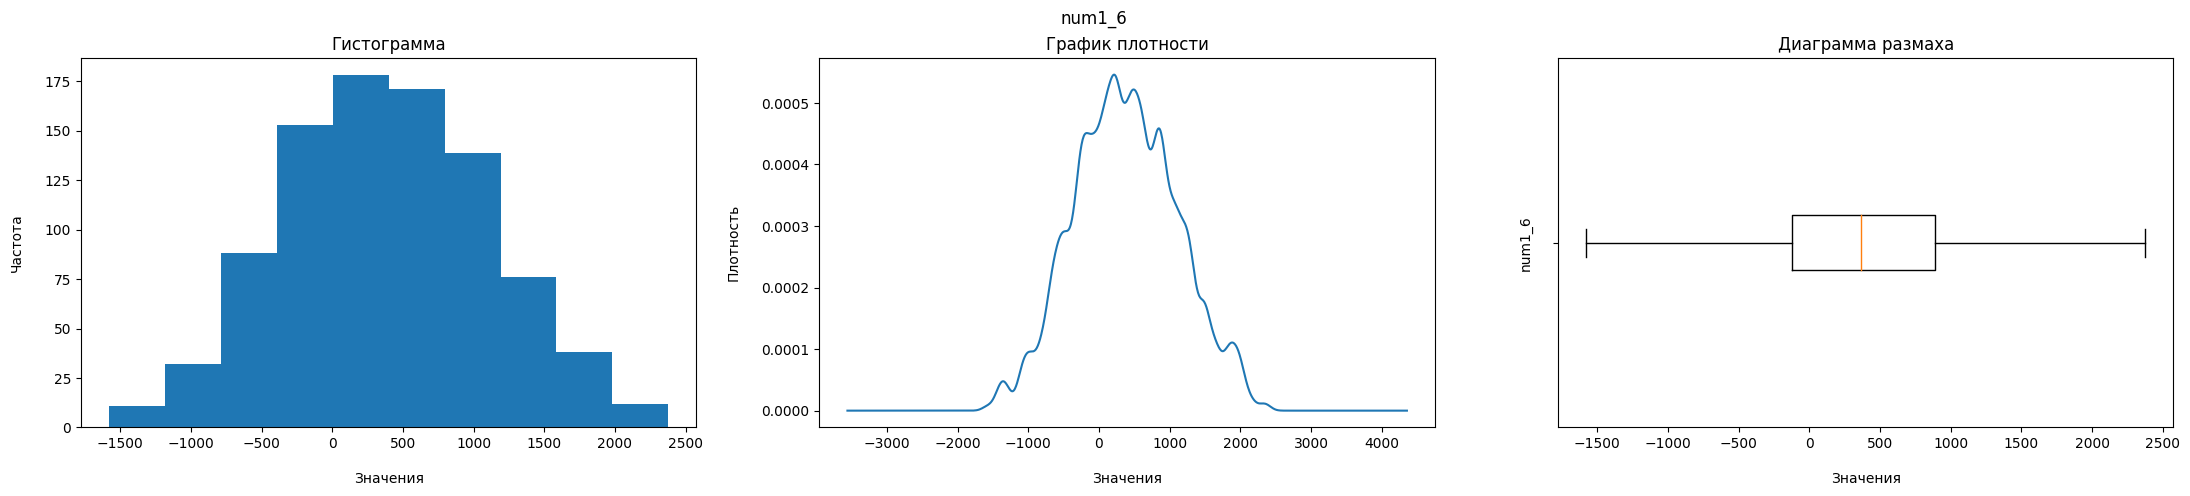

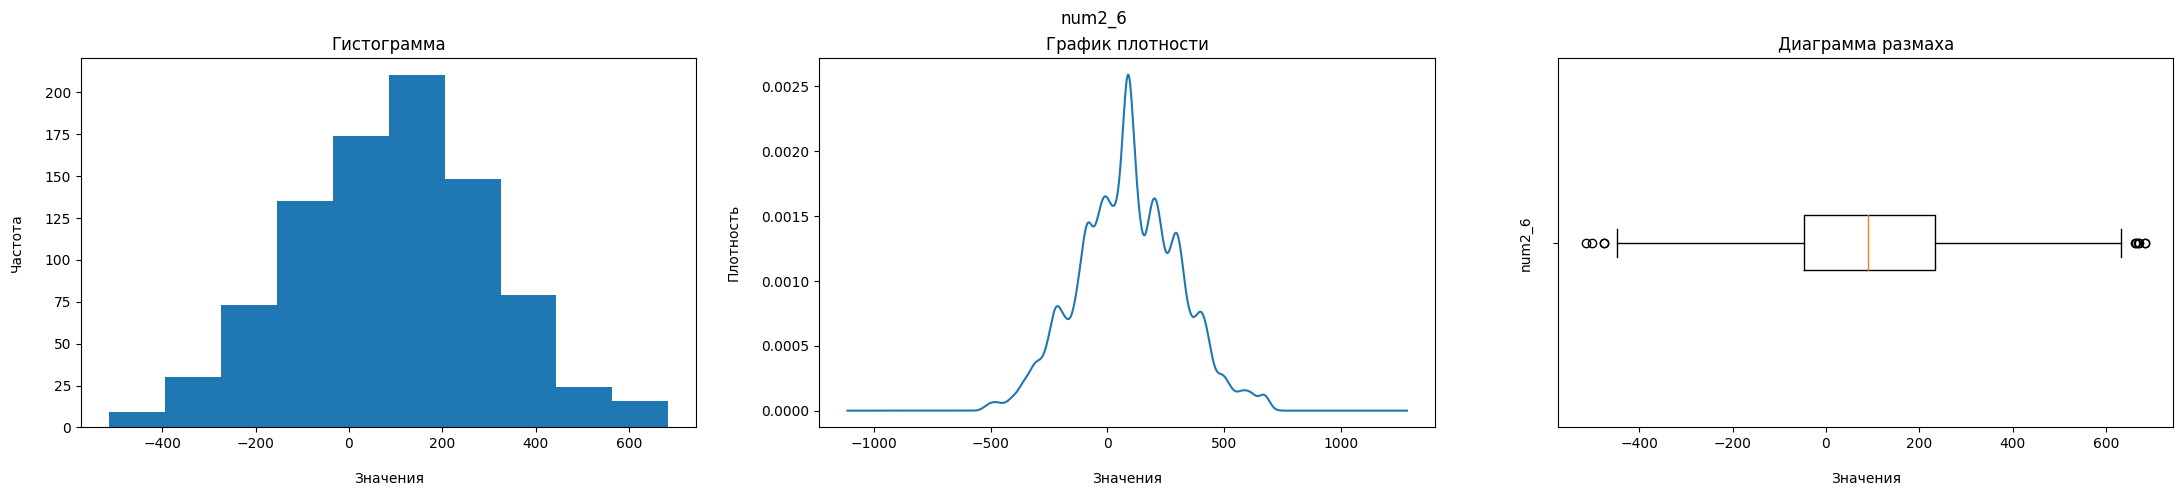

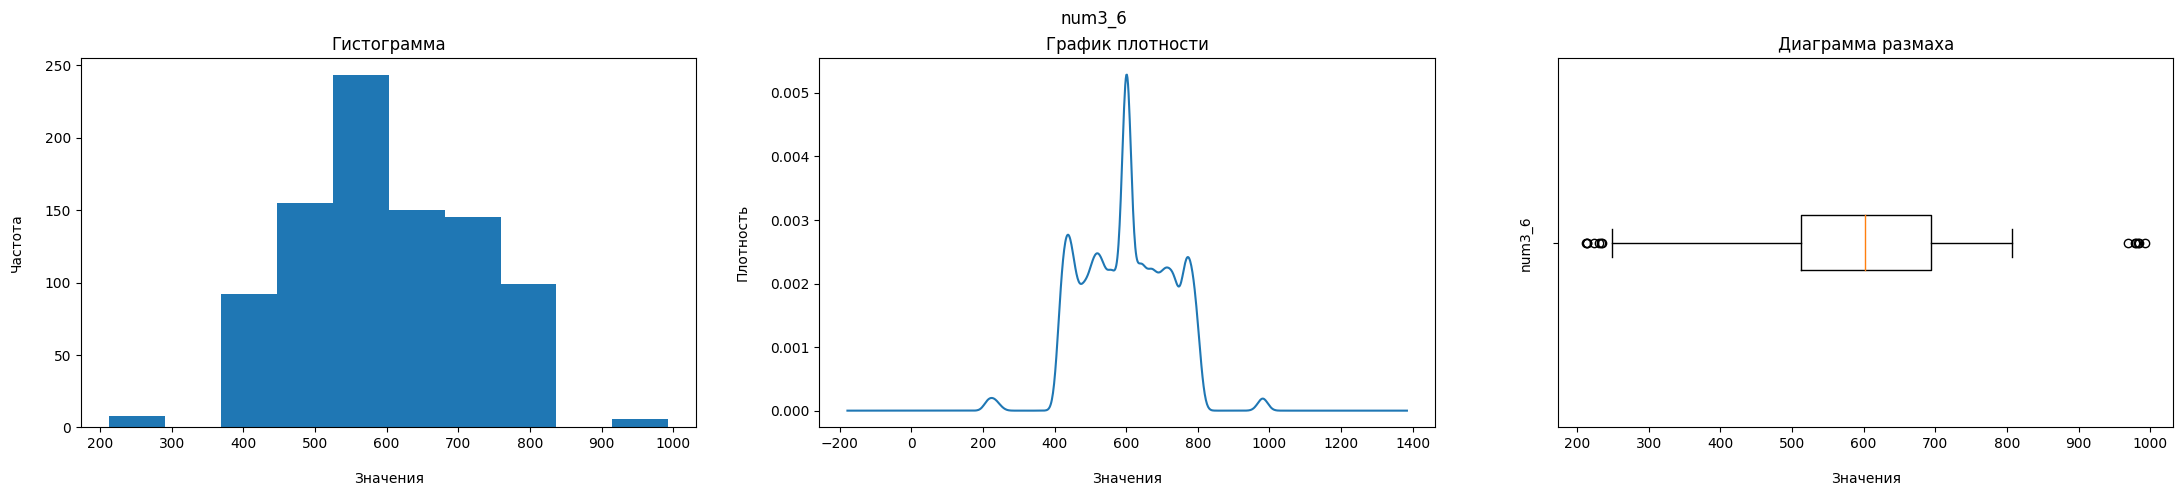

In [14]:
for col in qualitative:
    build_qualitative_charts(data[col], col)

for col in quantitative:
    build_quantitative_charts(data[col], col)